In [1]:
%run ../common_functions.py

read_dataset()
read_all_datasets()
read_processed_data()
combine_text_columns()
split_train_test()
extract_data()
evaluate_model()
detect_missing_values()


In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sentence_transformers import SentenceTransformer
import torch

## Load in Dataset

In [4]:
train_data, test_data = read_processed_data(augmented=False, balanced=False)

## Train k-Nearest-Neighbour

### Extract data and label mapping

In [6]:
X_train, y_train, X_test, y_test = extract_data(train_df=train_data, test_df=test_data, text_col='text', label_col='label')

### Transform to Vectors

In [7]:
device = torch.device("cuda" if torch.cuda.is_available()
                      else "mps" if torch.backends.mps.is_available()
                      else "cpu")
print(f"Using device >> {device}")

embedder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device=device)

X_train_emb = embedder.encode(
    X_train, batch_size=48, show_progress_bar=True
)

X_test_emb = embedder.encode(
    X_test, batch_size=48
)

Using device >> mps


Batches:   0%|          | 0/6085 [00:00<?, ?it/s]

In [8]:
model = KNeighborsClassifier(
    n_neighbors=70,
    weights='distance',
    metric='cosine',
    n_jobs=-1
)
model.fit(X_train_emb, y_train)

,n_neighbors,70
,weights,'distance'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'cosine'
,metric_params,None
,n_jobs,-1


Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.93      0.66     13006
           1       0.72      0.17      0.27     14139

    accuracy                           0.53     27145
   macro avg       0.61      0.55      0.46     27145
weighted avg       0.62      0.53      0.46     27145


Overall Metrics:
Accuracy       : 0.5324
Precision (avg): 0.6166
Recall    (avg): 0.5324
F1 Score  (avg): 0.4562



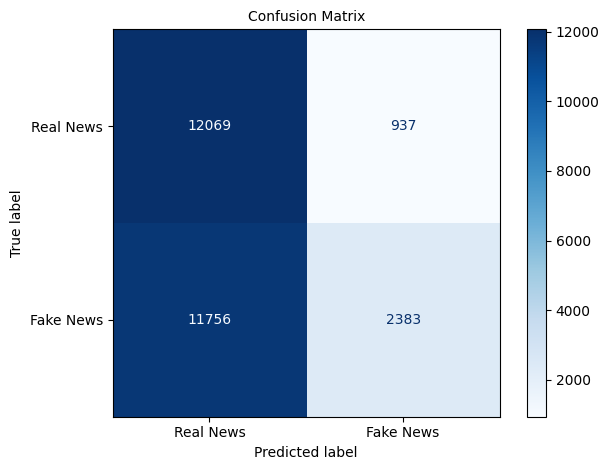

In [9]:
y_pred = model.predict(X_test_emb)
evaluate_model(y_test=y_test, y_pred=y_pred)

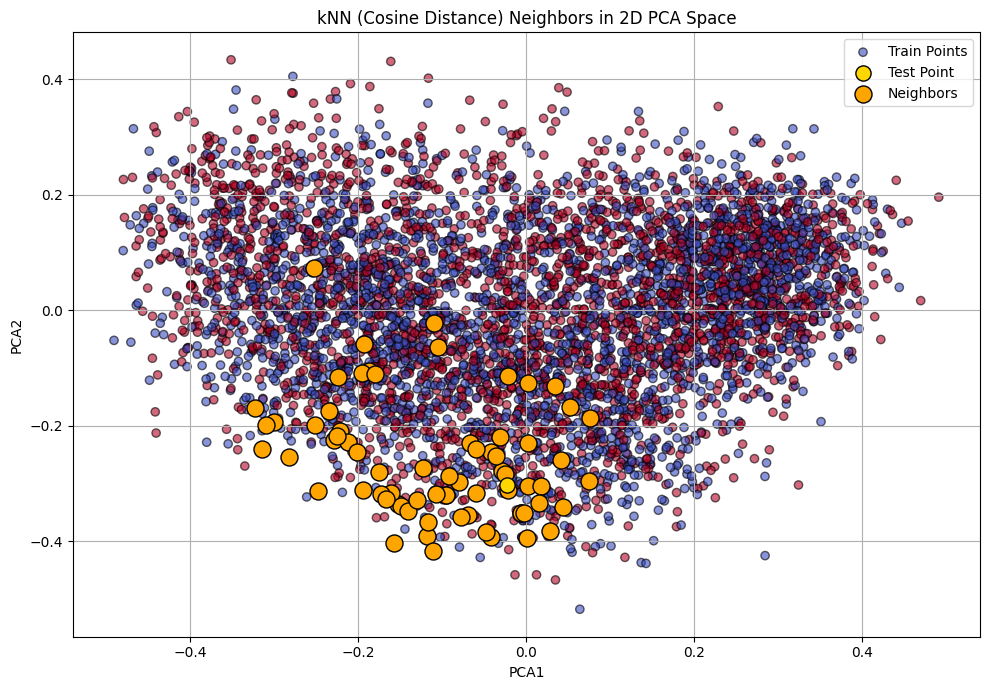

In [25]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from random import randint

# PCA projection to 2D
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train_emb)
X_test_2d = pca.transform(X_test_emb)

# Choose a test point
test_index = randint(0, len(X_test_emb))
test_point_emb = X_test_emb[test_index].reshape(1, -1)
test_point_2d = X_test_2d[test_index].reshape(1, -1)

# Get k nearest neighbors in original space
_, neighbor_idxs = model.kneighbors(test_point_emb)
neighbors_2d = X_train_2d[neighbor_idxs[0]]

# Limit number of training points plotted for clarity
sample_size = 5000
np.random.seed(42)
sample_indices = np.random.choice(len(X_train_2d), size=sample_size, replace=False)
X_sampled_2d = X_train_2d[sample_indices]
y_sampled = y_train[sample_indices]

# Plotting
plt.figure(figsize=(10, 7))
plt.scatter(X_sampled_2d[:, 0], X_sampled_2d[:, 1], c=y_sampled,
            cmap='coolwarm', edgecolor='k', alpha=0.6, label='Train Points')
plt.scatter(test_point_2d[:, 0], test_point_2d[:, 1], c='gold', s=120,
            label='Test Point', edgecolor='black', zorder=5)
plt.scatter(neighbors_2d[:, 0], neighbors_2d[:, 1], c='orange',
            edgecolors='black', s=150, label='Neighbors', zorder=4)

plt.title("kNN (Cosine Distance) Neighbors in 2D PCA Space")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()